In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from IPython.display import clear_output
import os
import mysql.connector
import csv_getters.helper_functions as hf
from csv_getters.config import conn_host, conn_database, conn_user, conn_password
import json
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

In [2]:
def connect_to_db():
    return mysql.connector.connect(host=conn_host, 
                                     database=conn_database,
                                     user=conn_user,
                                     password=conn_password)

def execute_query(query, read_only = True):
    resp = None
    try:
        db = connect_to_db()
        if read_only:
            resp = pd.read_sql_query(query, db)
        else:
            mycursor = db.cursor()
            mycursor.execute(query)

            db.commit()
        db.close()
    except Exception as e:
        print(e)
    return resp

In [126]:
first_season = 2021
last_season = 2022

min_games = 5
n_last_games = 5
default_odds = 1.9
default_bet_value = 10

min_threshold = 60
max_threshold = 40

pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
season_games = execute_query(f"SELECT g.id, g.date, g.season, g.is_playoff, g.winner, g.home_id, ht.name as home_name, g.home_pts, g.home_fgm, g.home_fga, g.home_fg_pct, g.home_fg3m, g.home_fg3a, g.home_fg3_pct, g.home_ftm, g.home_fta, g.home_ft_pct, g.home_oreb, g.home_dreb, g.home_reb, g.home_ast, g.home_stl, g.home_blk, g.home_tov, g.home_pf, g.away_id, at.name as away_name, g.away_pts, g.away_fgm, g.away_fga, g.away_fg_pct, g.away_fg3m, g.away_fg3a, g.away_fg3_pct, g.away_ftm, g.away_fta, g.away_ft_pct, g.away_oreb, g.away_dreb, g.away_reb, g.away_ast, g.away_stl, g.away_blk, g.away_tov, g.away_pf, g.home_odds, g.away_odds, g.over_under_line FROM games AS g LEFT JOIN teams as ht ON g.home_id = ht.id LEFT JOIN teams as at ON g.away_id = at.id WHERE g.season >= {first_season} and g.season <= {last_season} and g.over_under_line IS NOT NULL ORDER BY g.date ASC")

C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
season_games.head()

,id,date,season,is_playoff,winner,home_id,home_name,home_pts,home_fgm,home_fga,...,away_dreb,away_reb,away_ast,away_stl,away_blk,away_tov,away_pf,home_odds,away_odds,over_under_line
0,20800001,2008-10-28,2008,0,H,1610612738,Boston Celtics,90,33,74,...,33,41,16,8,2,22,26,1.36,3.15,182.5
1,20800002,2008-10-28,2008,0,H,1610612741,Chicago Bulls,108,35,69,...,19,32,21,5,3,19,30,1.36,3.20,198.0
2,20800003,2008-10-28,2008,0,H,1610612747,Los Angeles Lakers,96,37,79,...,31,44,19,8,3,14,17,1.27,3.85,195.0
3,20800004,2008-10-29,2008,0,A,1610612753,Orlando Magic,85,32,87,...,35,53,17,10,7,15,23,1.25,3.95,202.5
4,20800005,2008-10-29,2008,0,A,1610612755,Philadelphia 76ers,84,29,84,...,23,33,24,8,5,10,23,1.46,2.72,187.5


In [6]:
def get_team_made_conceded_pct(games, line):
    made = np.array(games['team_pts'])
    conceded = np.array(games['opp_pts'])
    totals = made + conceded
    greater = (totals > line).sum()
    pct = greater*100/len(totals)
    return pct

def get_team_info(team_id, game_date, season, line, scenario):
    response = hf.get_team_previous_games(season_games, team_id, game_date, season)
    if not response: return None
    
    home_previous_games, away_previous_games, previous_games, previous_season_games = response
    
    if len(previous_season_games.index) < min_games:
        return None
    
    overall_pct = get_team_made_conceded_pct(previous_season_games.iloc[-n_last_games:,:], line)
    if scenario == 'H':
        ha_pct = get_team_made_conceded_pct(home_previous_games.iloc[-n_last_games:,:], line)
    else:
        ha_pct = get_team_made_conceded_pct(away_previous_games.iloc[-n_last_games:,:], line)
    return overall_pct, ha_pct
    
    

In [127]:
season_itr = first_season

results = dict()

while season_itr < last_season:
    rights = 0
    total = 0
    profit = 0
    over = 0
    under = 0
    games_filtered = season_games.loc[season_games['season'] == season_itr].reset_index(drop=True)
    dates = [games_filtered.iloc[0,:]['date']]
    profit_tracking = [0]
    for index, game in games_filtered.iterrows():
        clear_output(wait=True)
        print(f"Season {season_itr}/{last_season}: {index}/{len(games_filtered.index)}")

        if game['date'] != dates[-1]:
            dates.append(game['date'])
            profit_tracking.append(profit_tracking[-1])

        response = get_team_info(game['home_id'], game['date'], game['season'], game['over_under_line'], 'H')
        if not response: continue

        home_overall_pct, home_ha_pct = response

        response = get_team_info(game['away_id'], game['date'], game['season'], game['over_under_line'], 'A')
        if not response: continue

        away_overall_pct, away_ha_pct = response

        if game['home_pts'] + game['away_pts'] > game['over_under_line']:
            over += 1
        elif game['home_pts'] + game['away_pts'] < game['over_under_line']:
            under += 1
            
        game_money = 0
        array_converted = np.array([home_overall_pct, home_ha_pct, away_overall_pct, away_ha_pct])
        if min(home_overall_pct, home_ha_pct, away_overall_pct, away_ha_pct) > max_threshold:
            print('over', array_converted)
            if game['home_pts'] + game['away_pts'] > game['over_under_line']:
                rights += 1
                game_money = default_bet_value * (default_odds-1)
            else:
                game_money = -default_bet_value
            total += 1
        elif max(home_overall_pct, home_ha_pct, away_overall_pct, away_ha_pct) < min_threshold:
            print('under', array_converted)
            if game['home_pts'] + game['away_pts'] < game['over_under_line']:
                rights += 1
                game_money = default_bet_value * (default_odds-1)
            else:
                game_money = -default_bet_value
            total += 1

        profit_tracking[-1] += game_money
        profit += game_money
        
    results[season_itr] = {
        'rights': rights,
        'total': total,
        'profit': profit,
        'dates': dates,
        'over': over,
        'under': under,
        'profit_tracking': profit_tracking
    }
    season_itr += 1

Season 2021/2022: 1316/1317


In [128]:
def plot_progression_chart(result, season):
    print(f"\n{season} results:")
    print(f"{result['rights']} hits out of {result['total']}")
    print(f"{result['over']} times over the totals line")
    print(f"{result['under']} times under the totals line")
    print(f"Strike rate: {result['rights']*100/result['total']}")
    print(f"Profit: ${result['profit']}")
    
    xpoints = np.array(result['dates']).astype(np.datetime64)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.plot(xpoints, np.array(result['profit_tracking']))

    title = f"Profit by Date ({season})"
    plt.ylabel("Profit($)")
    plt.xlabel("Date")
    plt.title(title)
    plt.gcf().autofmt_xdate()
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()


2021 results:
123 hits out of 293
618 times over the totals line
599 times under the totals line
Strike rate: 41.97952218430034
Profit: $-593.0


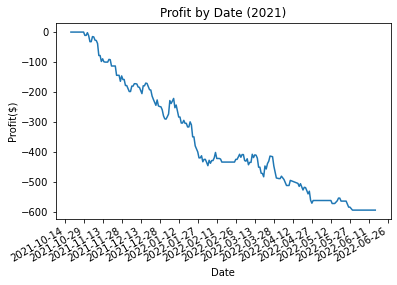

In [129]:
profit_sum = 0
for season in results:
    profit_sum += results[season]['profit']
    plot_progression_chart(results[season], season)

In [130]:
print(f"Total profit: ${profit_sum}")

Total profit: $-593.0


In [131]:
print(min(array_converted))

40.0
